# Gaussian Process Regression

The purpose of this notebook is to introduce **Gaussian Process Regression**. The notebook will introduce in the order of statistical explanation, implementations, and hyperparameter tuning. Many contents of this notebook will based on the prerequisite concepts explained in the *fundamental.ipynb* file.
- **Mathematic Derivation & Definition**
    1. Definition of Gaussian Process (GP)
    2. Definition of Gaussian Process Regression (GPR)
    3. Pros/Cons of GPR
    4. Origination of GPR
    5. Derivation of GPR
    6. Kernel Function in GPR
    7. Sizes of terms
    8. Simple Illustration of GPR
    9. Testing Size and Smoothness of Output
    10. Common Confusions about GPR
    11. GPR with Multidimension Data
- **Gaussian Process Regression Implementation Codes**
    1. GPR From Scratch Code
    2. GPR interactive visualization
    3. The role of hyperparameters
    4. GPR with Multidimensional Data
    5. GP Using Libraries
- **Gaussian Process Hyperparameter Tuning**
    1. Mathematic Foundation
    2. Gradient Based Methods
    3. Implementation in GPytorch
    4. Rationale behind tuning hyperparameters


### **Mathematic Derivation & Definition**

#### 1.Definition of Gaussian Process(GP)
A **Gaussian Process (GP)** is a stochastic process that defines a distribution over **functions** rather than just over points. Formally, a GP is a collection of **random variables** where any finite subset follows a **multivariate Gaussian distribution**. A gaussian process is represented as:
$$f\sim \mathcal{GP}(\mu(x),k(x,x'))$$
- $f$ is the function that follows the GP (which is also our target when using GP to make predictions)
- A gaussian process, like gaussian distribution, are defined by only two terms: **mean function** $\mu(x)$ and **kernel (covariance) function** $k(x,x')$.
- The mean function $\mu(x)$ represents the **Expected Value** of the function $f$ given any input $x$.
- The **kernel (covariance) function** $k(x,x')$ captures how function values at different inputs $x$ and $x'$ are related.- GP assumes that function values near each other are correlated in a way dictated by the covariance function (key for generating smooth prediction).

The terminologies seem intimidating, but a gaussian process can be easily understood by the plot below:
<div style="text-align: center"> <img src="https://www.lancaster.ac.uk/stor-i-student-sites/thomas-newman/wp-content/uploads/sites/37/2022/05/Gaussian-process-with-noise.svg" alt="Drawing" width="500"/> </div>

The plot shown here involves training datas ($\times$), some functions, and a shade area. In a gaussian distribution of a random variable (explained in the *fundamental* notebook), we model the distribution of datapoints. Here in GP, we model **the distribution of functions that go through (or nearby, controlled by a hyperparameter explained later) training points**. The shaded area represents the distribution of the **function**, and the functions shown above are some subsets of the distribution. The **bold** function shown in the plot represents the value of **mean function $\mu(x)$**, the most possible function value. The shaded area is dictated by the **kernel(covariance) function**.

#### 2.Definition of Gaussian Process Regression(GPR)
Gaussian Process Regression (GPR) is a Bayesian, nonparametric regression method in which we model an unknown function $f(x)$ as being **drawn from a Gaussian process**. 
Note that gaussian process is **NOT** a machine learning model for prediction. It only describes **Distribution of a function**. Gaussian process can be used to peform multiple tasks, including regression and classification. Here, we focus on **Gaussian Process Regression**, a supervised machine learning model that is cabable of predicting function regardless of its form using gaussian process while also providing uncertainty of the prediction. 

Recall that a regression is a model the relationship between input variables (features $X$) and a **continuous** output variable (Label $Y$):
$$Y=f(X)+\epsilon,\,\epsilon\sim\mathcal{N}(0,\sigma^2)$$

Recall that in the case where the function has a fixed form (linear regression), we use true bayesian prediction to obtain a predictive distribution of label $\hat{Y}$:
$$P(\hat{Y}|X,Y,\hat{X})=\int_{\theta} P(\hat{Y}|\theta,X,Y)P(\theta|X,Y)d\theta$$
The predictive distribution involves a prior $P(\theta)$ over parameter $\theta$, which we assumed to be gaussian in the previous example:
$$P(\theta)\sim \mathcal{N}(0,\tau^2I)$$

**In GPR**, the goal is to predict the function $f$ directly, regardless of its form. Thus, assuming a prior over parameter $\theta$ is **unrealistic**, since the form of $\theta$ is unknown. Instead, we put a **GP prior** over the function which we try to predict. (you can think of that before we have an assumption of $\theta$, now we have an assumption of $f$. Since the distribution of a function is a gaussian process, we use notation $\mathcal{GP}$ instead of $P$.)
$$ \begin{align}
P(\hat{Y}|X,Y,\hat{X})&=\int_{f} P(\hat{Y}|f)P(f|X,Y)df \\
f&\sim \mathcal{GP}(\mu,k)
\end{align}$$


#### 2. Pros/Cons of GPR
##### Advantages of GPR
1. GPR is very powerful in predicting functions in **any form**. Unlike other models that stick with one particular function form (like linear regression for linear model), GP learns the function from the data.
2. GPR uses **Bayesian Approach**, incorporating prior knowledge and allow for principled Bayesian inference, making them adaptable to different domains (for reference MAP/True bayesian prediction in fundamental notebook).
3. GPR is a probabilistic model, whose output not only provides the most probable value (mean function), but also **uncertainty** of the value.
4. GPR does **not require a large dataset**, which is very friendly to the situation where data collection is time-consuming and expensive.
5. The choice of **kernel function** allows GPs to capture various data patterns, such as periodicity, smoothness, or sudden changes.
##### Disadvantages of GPR
1. GPR is computationally **expensive and complex**. This will be explained in later parts.
2. GPR does not work ideally with **large datasets ($n>10^6$)**, primarily because its complexity.
3. GPR does not work ideally with **high dimensional settings**.
4. Choosing kernel functions could be tricky, and it dictates the overall performance of GP.
5. Hyperparameter tuning is challenging.

#### 3. Origination of GPR
The origination of GPR as a powerful model to predict any arbitraty shape function $f$  with uncertainty comes from several aspects.
##### Bayesian Approach
As introduced and explained in the *fundamental* notebook, **bayesian approach** is very powerful at making predictions of model parameters (MLE and MAP). In addition, a **true bayesian prediction** provides uncertainty on top of the prediction itself, making it very useful in many usecase where uncertainty is necessary to obtain. Therefore, gaussian process natually emerges as a model using the bayesian approach.
##### Universality of Gaussian Distribution
Bayesian Approach relies on previous assumptions/knowledge of the distribution (**Prior**) to infer the posterior. This means choosing a **reliable** prior is critical. As shown in the *fundamental* notebook, a **gaussian prior** is the popular choice, due to the universality of gaussian process, and most importantly the **central limit theorem(CLT)**. This property also extends to **gaussian process prior**.

In addition, **operations** among gaussian distributions (addition, multiplication, integration, etc) result in **another gaussian** in most cases. 

These two reasons make choosing a gaussian process prior reasonable. Therefore, a GPR places a gaussian process prior in the model (why it named "gaussian" process).
##### Closed Form of Predictive Distribution
In true bayesian prediction, the **Predictive Distribution** is calculated by integrating over all parameter $\theta$ in the case of fixed function form regression; and integrating over all function $f$ inthe case of gaussian process regression:
$$\begin{align}
P(\hat{Y}|X,Y,\hat{X})&=\int_{\theta} P(\hat{Y}|\theta,X,Y)P(\theta|X,Y)d\theta \\
P(\hat{Y}|X,Y,\hat{X})&=\int_{f} P(\hat{Y}|f)P(f|X,Y)df
\end{align}$$
The indefinite integral is **computationally complex**, and rarely has a **closed form**. In the case of gaussian distribution, a **closed form is available**. This is the key why a GPR can leverage true bayesian prediction as its approach to peform modeling.

#### 4.Derivation of GPR
Recall that for a regression problem, our goal is that given training feature $X$ and training label$Y$, we want to find the unknown function that maps $X$ to $Y$:
$$Y=f(X)+\epsilon, \,\epsilon\sim\mathcal{N}(0,\sigma^2)$$
As Stated above, GPR uses bayesian approach to infer the predictive distribution of function $f(x)$:
$$P(\hat{Y}|X,Y,\hat{X})=\int_{f} P(\hat{Y}|f)P(f|X,Y)df$$

##### Gaussian Conditioning Formula
In the derivation of the predictive distribution, the **Gaussian Conditioning Formula** is frequently used to bypass the cpmlex explicit calculation (specifically the integral).

For two multivariate gaussian random Variable $A$ and $B$:
$$\begin{align}
A&\sim\mathcal{N}(\mu_A,\Sigma_{AA})
B&\sim\mathcal{N}(\mu_B,\Sigma_AA)
\end{align}$$
The joint distribution between $A$ and $B$ is:
$$\begin{bmatrix} A \\ B  \end{bmatrix}\sim\mathcal{N}
\begin{pmatrix}
\begin{bmatrix} \mu_A \\ \mu_B \\ \end{bmatrix} &&
\begin{bmatrix} \Sigma_{AA} && \Sigma_{AB} \\ \Sigma_{BA} && \Sigma_{BB} \end{bmatrix}
\end{pmatrix}
$$
And the conditional distribution $P(B|A)$ is:
$$P(B|A)\sim\mathcal{N}(mu_B+\Sigma_{BA}\Sigma_{AA}^{-1}(A-\mu_A),
        \Sigma_{BB}-\Sigma_{BA}\Sigma_{AA}^{-1}\Sigma_{AB})$$
##### What is the posterior $P(f|X,Y)$
This step is very similar to the posterior function in bayesian linear regression, we use bayes's theorem to infer:
$$P(f|X,Y)\propto P(Y|f)P(f|X)$$
The only difference is that here the prior is a **GP Prior** over $f$:
$$P(f|X)\sim\mathcal{GP}(m(X),K(X,X))$$
where
- $m(X)$ is the mean function evaluated at $X$, and <span style="color: red;"> It is assumed that  m(X)=0 in the gaussian prior. </span>
- $K(X,X) is the **Covariance Matrix**, where entry $K_{ij}=k(X_i,X_j)$, $k(x,x')$ being the chosen kernel function.

$P(Y|f)$ is just the function value with noise:
$$P(Y|f)\sim\mathcal{GP}(m(X),K(X,X)+\sigma^2I)
$$

The **joint distritbuion** of $f(X)$ and $Y$ is:
$$\begin{bmatrix} f(X) \\ Y  \end{bmatrix}\sim\mathcal{N}
\begin{pmatrix}
\begin{bmatrix} m(X) \\ m(X) \\ \end{bmatrix} &&
\begin{bmatrix} K(X,X) && K(X,X) \\ K(X,X) && K(X,X)+\sigma^2I \end{bmatrix}
\end{pmatrix}
$$

Using the **Gaussian Conditioning Formula**,
$$\begin{align}
P(f|X,Y)&=P(f(X)|Y)\sim\mathcal{N}(\mu_f,\Sigma_f) \notag \\
\mu_f &= K(X,X)[K(X,X)+\sigma^2I]^{-1}(Y-m(X)) \notag \\
&=K(X,X)[K(X,X)+\sigma^2I]^{-1}Y \\
\Sigma_f &= K(X,X)-K(X,X)[K(X,X)+\sigma^2I]^{-1}K(X,X)
\end{align}$$

##### What is $P(\hat Y|f)$
The model prediction is just the function output:
$$P(\hat Y|f)\sim\mathcal{N}(m(\hat X),K(\hat X,\hat X))$$

##### Predictive Distribution
To derive the predictive distribution, we don't have to explicitly calculate the integral, because the result of the integral is analytically equal to another gaussian conditioning (both terms under integration are gaussian). The joint distribution of $Y$ and $f(\hat X)$ is:
$$\begin{bmatrix} Y \\ f(\hat X) \end{bmatrix}\sim\mathcal{N}
\begin{pmatrix}
\begin{bmatrix} m(X) \\ m(\hat X) \\ \end{bmatrix} &&
\begin{bmatrix} K(X,X)+\sigma^2I && K(\hat X ,X) \\ K (\hat X,X) && K(\hat X,\hat X) \end{bmatrix}
\end{pmatrix}
$$
Using the **Gaussian Conditioning Formula**,
$$\begin{align}
P(\hat Y|X,Y,\hat X)&=P(f(\hat X)|Y)\sim\mathcal{N}(\mu_*,\Sigma_*) \notag \\
\mu_* &= K_*^T[K+\sigma^2I]^{-1}Y \notag \\
\Sigma_* &= K_{**}-K_*^T[K+\sigma^2I]^{-1}K_*
\end{align}$$
Couple Notes:
- $K=K(X,X)$ is the **Training Kernel Matrix**
- $K_*=K(X,\hat X)$ is the **Training& Testing Covariance Matrix**
- $K_{**}=K(\hat X,\hat X)$ is the **Testing Kernel Matrix**

#### 6.Kernel Function in GPR
A kernel function (also called a covariance function) defines the similarity between data points in Gaussian Process Regression. It specifies how much influence one point has on another, determining the structure of the function space that GPR models. It is extremely important in **GPR** because it controls **smoothness, periodicity, and variability** of the function learned.With that said, choosing an appropriate kernel function is critical.

Before we dive in to determine the form of kernel function, we need to identify the requirements on the kernel function. We recognize that for kernel matrix $K$, where $K_ij=k(X,X')$:
1. The Diagonal of the matrix must represent the variance of the distribution. This is because we need to satisfy gaussian prior:
$$K_{ii}=k(X_i,X_i)=Var(X_i)$$
2. $K$ is always **Positive semi-definite**, because variance/covariance **cannot be negative**.
3. If $X_i$ and $X_j$ are very **independent**, i.e.$X_i$ and $X_j$ are very different from each other, $K(X_i,X_j)=0$.
4. If $X_i$ and $X_j$ are very **similar**, $K(X_i,X_j)>0$.

##### Radial Basis Function (RBF) Kernel
A very popular kernel function that satisfies all the requirements mentioned above is the **RBF** kernel, which defines similarity with eucleadian distance:
$$K(X_i,X_j)=\tau \exp \frac{-||X_i-X_j||^2}{2l^2}$$
where
- $tau$ is the prefactor (coefficient)of the model. Sometimes it is also called $\sigma^2$, but may cause confusion because there is another $\sigma^2$ in the model which is the observation noise variance.
- $l$ is the lengthscale. Controls how far the influence of each data point extends. A larger $l$ means smoother functions, while a smaller $l$ allows rapid changes.
- $||X_i-X_j||^2$ is the eucleadian distance between the two feature vectors.

#### 7.Sizes of terms
There are a lot of matrices involved in a Gaussian Process Regression. It is beneficial to sort out all of their sizes to ensure that the computation and results are truly what we want. Here is a summarized table for all the matrices and their sizes in GPR:
<div align="center">

| Matrix         | Description                           | Size   |
|---------------|-------------------------------------|--------|
| $X$             | Training input matrix               | $d × n$  |
| $Y$             | Training output vector             | $1 × n$  |
| $\hat{X}$    | Prediction input matrix                  | $d × m$  |
| $\hat{Y}$    | Prediction output vector                 | $1 × m$  |
| $K$            | Training Kernel Matrix                     | $n × n$  |
| $K_*$             | Training&Testing Covariance Matrix    | $n × m$ |
| $K_*^T$             | Transpose of Training&Testing Covariance Matrix    | $m × n$ |
| $K_{**}$             | Testing Kernel Matrix                   |$m × m$|
| $\mu_*$          | Predictive Mean               | $ 1× m $  |
| $\Sigma_*$          | Predictive covariance              | $m × m$  |


#### 8.Simple Illustration of GPR
Understanding all those abstract math representations of a bunch of matrices could be challenging. Here is a very simplified example of only 2 training points, and we attempt to make only one prediction.
##### Set up
In our simplified set-up, We have only **two training points** on a plane:
$$
X=\begin{bmatrix} 1.5, 4  \end{bmatrix},\,
Y=\begin{bmatrix} 2, 5  \end{bmatrix}
$$
And we want to make **1 prediction(testing point) at $\hat X=2$**.
<div style="text-align: center"> <img src="images/Simp_1.png" alt="Drawing" width="250"/> </div>

To comprehend how GPR is performed without any abstract math, we summarize it as a question: Given the **known** datapoints; the **trend** among known datapoints;,and the **similarity** between testing point and datapoints, what is the most likely testing output, and how certain we are about it?

Suppose we have two prediction candidates: $[2,2.2]$ and $[2,4.5]$. It is obvious that $[2,2.2]$ is more probable, because 
1. The slope between two training points is positive.
2. Testing input $\hat X=2$ is close to the training point$X=1.5$, so its corresponding label should be closer to that of $X=1.5$.

 The image below illustrates this approach:
<div style="text-align: center"> <img src="images/Simp_2.png" alt="Drawing" width="250"/> </div>

Now, we understand the priciples behind a gaussian process, let's go ahead and define all the covariance matrices in addition to $X$, $Y$, and $\hat X$:
$$\begin{align}
K&=\begin{bmatrix}
\tau e^{\frac{-(X_1-X_1) ^2}{2l^2}} & \tau e^{\frac{-(X_1-X_2) ^2}{2l^2}} \\
\tau e^{\frac{-(X_2-X_1)^2}{2l^2}} & \tau e^{\frac{-(X_2-X_2)^2}{2l^2}} \\
\end{bmatrix} \\
K_{*}&=\begin{bmatrix}
\tau e^{\frac{-(X_1-\hat X_1)^2}{2l^2}}  \\
\tau e^{\frac{-(X_2-\hat X_1)^2}{2l^2}}  \\
\end{bmatrix} \\
K_{**}&=\begin{bmatrix}
\tau e^{\frac{-(\hat X_{1}-\hat X_{1}) ^2}{2l^2}}
\end{bmatrix}
\end{align}$$

Then we proceed to calculate predictive distribution mean and covariance matrix, applying:
$$\begin{align}
\mu_* &= K_*^T[K+\sigma^2I]^{-1}Y \notag \\
\Sigma_* &= K_{**}-K_*^T[K+\sigma^2I]^{-1}K_* \\
&\text{assuming:} \sigma^2=1
\end{align}$$

The result is:
$$\begin{align}
\mu_{*}=[2.20],\,\Sigma_{*}=[0.0227] \notag \\
STD=Diag(\Sigma_*)=[0.0227]
\end{align}$$
<div style="text-align: center"> <img src="images/Simp_3.png" alt="Drawing" width="600"/> </div>

At last, it is always safe to make sure that the matrix sizes make sense.
<div align="center">

| Terms        | Description                           | Size   |
|---------------|-------------------------------------|--------|
| $d$             | Feature Dimension               | $1$  |
| $n$             | Number of Training Points               | $2$  |
| $m$             | Number of Testing Points               | $1$  |
| $X$             | Training input matrix               | $d × n = 1 × 2$  |
| $Y$             | Training output vector             | $1 × n = 1 × 1$  |
| $\hat{X}$    | Prediction input matrix                  | $d × m = 1 × 1$  |
| $\hat{Y}$    | Prediction output vector                 | $1 × m = 1 × 1$  |
| $K$            | Training Kernel Matrix                     | $n × n = 2 × 2$  |
| $K_*$             | Training&Testing Covariance Matrix    | $n × m = 2 × 1$ |
| $K_*^T$             | Transpose of Training&Testing Covariance Matrix    | $m × n = 1 × 2$ |
| $K_{**}$             | Testing Kernel Matrix                   |$m × m = 1 × 1$|
| $\mu_*$          | Predictive Mean               | $ 1× m  = 1 × 1$  |
| $\Sigma_*$          | Predictive covariance              | $m × m = 1 × 1$  |


#### 9. Testing Size and Smoothness of Output
Testing Size is closely related to the smoothness of the output function. Let's say we have 100 testing points, evenly distributed between 0 and 5, in the previous simple example:
$$\begin{align}
X&=\begin{bmatrix} 1.5, 4  \end{bmatrix},\,
Y=\begin{bmatrix} 2, 5  \end{bmatrix} \notag \\
\hat X &= \begin{bmatrix} 0, 0.05, 0.10, 0.15, \cdots, 100 \end{bmatrix}
\end{align}$$

Our covariance matrices will become:
$$\begin{align}
K&=\begin{bmatrix}
\tau e^{\frac{-(X_1-X_1) ^2}{2l^2}} & \tau e^{\frac{-(X_1-X_2) ^2}{2l^2}} \\
\tau e^{\frac{-(X_2-X_1)^2}{2l^2}} & \tau e^{\frac{-(X_2-X_2)^2}{2l^2}} \\
\end{bmatrix} \\
K_{*}&=\begin{bmatrix}
\tau e^{\frac{-(X_1-\hat X_{1}) ^2}{2l^2}}  & 
\tau e^{\frac{-(X_1-\hat X_{2}) ^2}{2l^2}} & \cdots & \tau e^{\frac{-(X_1-\hat X_{100}) ^2}{2l^2}} \\
\tau e^{\frac{-(X_2-\hat X_{1}) ^2}{2l^2}}  & 
\tau e^{\frac{-(X_2-\hat X_{2}) ^2}{2l^2}} & \cdots & \tau e^{\frac{-(X_2-\hat X_{100}) ^2}{2l^2}} 
\end{bmatrix} \\
K_{**}&=\begin{bmatrix}
\tau e^{\frac{-(\hat X_1-\hat X_1) ^2}{2l^2}}  & 
\tau e^{\frac{-(\hat X_1-\hat X_2) ^2}{2l^2}} & \cdots & \tau e^{\frac{-(\hat X_1-\hat X_{100}) ^2}{2l^2}} \\
\tau e^{\frac{-(\hat X_2-\hat X_1) ^2}{2l^2}}  & 
\tau e^{\frac{-(\hat X_2-\hat X_2) ^2}{2l^2}} & \cdots & \tau e^{\frac{-(\hat X_2-\hat X_{100}) ^2}{2l^2}} \\
\vdots & \vdots & \ddots & \vdots \\
\tau e^{\frac{-(\hat X_{100}-\hat X_1) ^2}{2l^2}}  & 
\tau e^{\frac{-(\hat X_{100}-\hat X_2) ^2}{2l^2}} & \cdots & \tau e^{\frac{-(\hat X_{100}-\hat X_{100}) ^2}{2l^2}}\end{bmatrix}
\end{align}$$

The resulting plot will become:
<div style="text-align: center"> <img src="images/Simp_4.png" alt="Drawing" width="600"/> </div>

If we further expand the testing size to 1000, the output funciton will be smoother:
<div style="text-align: center"> <img src="images/Simp_5.png" alt="Drawing" width="600"/> </div>

#### 10.Common Confusions about GPR
##### Is "Tesing Data" the same as "Testing" in "Train/Test Split"?
**NO**, the testing data in a GPR is not the same as the term in train/test split. In train/test split, the testing data is a part of the avaible data that is preserved and **not** used in the process of model training. The purporse of testing data in train/test split is to have extra observed data to validate the model.

In **GPR**, testing data is a chosen set of interested inputs to obtain the predicted label from the GPR model. The confusion could be avoided if we use "predictive input" in stead of "testing data" here, but note that "testing data" is still occasionally used.

##### Does smoothness of the output depend on testing data size?
This is a common confusion between "the model" and "inquiry of the model". In GPR, the testing data (predictive input) is just a way for us to inquire a subset of the model. Just like in a sine model $Y=sin(X)$, if we inquire the model with a large interval (for example we input $X=[0.5,1,1.5,2]$), the output function will be squiggling(if we connect all the points with straight line). However, that does not mean that the model is not smooth. 

It is similar in GPR: when we inquire the predictive label value from a GPR model, the denser the points we include in testing data $\hat X$ within a certain interval, the smoother of a function we get (see exmaple above). **But** it does not mean the model is not smooth.

In summary, the density of testing data only increase the degree we "probe" the model. It is not related to the peformance of the model itself.

##### How to understand that GPR is a "Non-parametric" model yet it has "infinite parameters"?
GPR **does not assume a fixed form of the function that it is predicting**, and that is why it is described as a "non-parametric" model. However, "non-parametric" is sometimes considered as a minomer, because it does not correctly capture the nature of GPR.

In GPR, the model implicitly defines a function using infinite basis function expansion through kernel function. While a kernel function can be seen as an inner product in a high dimensional (possibly infinite dimensional) feature space. However, we don't have to explicitly compute all the dimensions, because the kernel function bypass it by only calculate the weighted sum of infinite number of basis function (called the kernel trick).

If this is still too abstract to comprehend, let's focus on how we **compute the predictive mean and predictive covariance matrix**. You may notice that their representation is **dependent on testing input $\hat X$**. 

This is very different from a parametric model, where the predicted function is fixed after training. But here, the predictive function is dependent on where we evaluate.If we evaluate infinitely large number of datapoints, there will be infinitely large number of "implicit parameters".

### **Gaussian Process Regression Implementation Codes**
In this part, GPR immplementation codes will be shown, both from scratch and with established python libraries like **GPytorch**.
#### 1.GPR From Scratch Code
Coding GPR from scratch helps consolidate the understanding of GPR. 
##### Define Kernel Function
Note that the euclidean distance in the following code is calculated by:
$$||X_i-X_j||^2=\sum{X_i^2}+\sum{X_j^2}-2X_i\cdot X_j$$
One can also be easily calculate it without breaking it down and use `np.linalg.norm(X1,X2)`.

In [319]:
import numpy as np
def kernel_rbf(X1, X2 = None, tau = 1.0, l = 1):
    """
    Computes the RBF kernel matrix between two sets of input vectors.
    
    Parameters:
    - X1: Array-like, shape (dimension_X1, n_X1)
      First set of input vectors.
    - X2: Array-like, shape (dimension_X2, n_X2) or None
      Second set of input vectors. If None, computes the kernel matrix for X with itself.
    - tau: float
      prefactor of the RBF kernel
    - l: float
      lengthscale of the RBF kernel
    
    Returns:
    - K: ndarray, shape (n_samples_X, n_samples_Y)
      Kernel matrix.
    """
    # Check if X2 is None
    if X2 is None:
        X2 = np.array(X1).copy()

    # Make sure X1 and X2 are np.array variables
    X1 = np.array(X1)
    X2 = np.array(X2)

    # Make sure X1 and X2 are 2D arrays
    if X1.ndim == 1:
        X1 = X1.reshape(-1, 1)
    if X2.ndim == 1:
        X2 = X2.reshape(-1, 1)

    # Validate input dimensions
    if X1.shape[1] != X2.shape[1]:
        raise ValueError("Number of features in X1 and X2 must match!")
    
    # Calculate Norm and reshape for broadcasting
    normX1 = np.sum(X1 ** 2, axis=1).reshape(-1,1)
    normX2 = np.sum(X2 ** 2, axis=1).reshape(1,-1)
    
    dot = np.dot(X1,X2.T)
    dis = normX1 + normX2 - 2 * dot
    return tau ** 2 * np.exp(-dis / (2*(l**2)))

##### Predictive Mean & Covariance Matrix Calculation
Next step, we implement the `kernel_rbf` function we just defined to compute predictive distribution.

In [320]:
def make_pred(X_train, Y_train, X_test, tau = 1.0, l = 1.0, sigma2 = 0.1):
    """
    Computes the predictive mean and predictive covariance matrix in GPR model.
    
    Parameters:
    - X_train: Array-like, shape (dimension, n)
      Training feature data.
    - Y_train: Array-like, shape (dimension, n)
      Training label data.
    - X_test: Array-like, shape (dimension, m)
      Testing label data.
    - tau: float
      prefactor of the RBF kernel
    - l: float
      lengthscale of the RBF kernel
    - sigma2: float
      Noise variance
    
    Returns:
    - mu_star: ndarray, shape (1, m)
      predictive mean vector.
    - cov_star: ndarray, shape (m, m)
      predictive covariance matrix.
    """

    # Check if training set is empty
    if X_train.size == 0:
        mu_star = np.zeros(len(X_test)) # If empty, mean is 0
        cov_star = kernel_rbf(X_test) # If empty, Cov is K**
        return mu_star, cov_star

    # Compute Covariance Matrices
    K = kernel_rbf(X_train, tau=tau, l=l) + sigma2 * np.eye(len(X_train)) # K
    K_s = kernel_rbf(X_train, X_test, tau=tau, l=l)  # K*
    K_ss = kernel_rbf(X_test,tau=tau, l=l)  # K**

    # Compute Predictive mean / covariance matrix
    mu_star = K_s.T @ np.linalg.inv(K + sigma2 * np.eye(X_train.shape[0])) @ Y_train  # Posterior mean
    cov_star = K_ss - K_s.T @ np.linalg.inv(K + sigma2 * np.eye(X_train.shape[0])) @ K_s  # Posterior covariance

    return mu_star, cov_star

##### Implement model
Let's choose a random function to verify the model. Here we generate 10 training points from the function:
$$Y=\sin(X)+\cos(\frac{X}{2})$$
And insert them into the model and plot the result. For testing input, we choose 1000 evenly separated X value points from 0-10.

**Feel free to change the number of training and testing points, as well as the function you want to predict (or just randomly sampled points with no specific shape)**

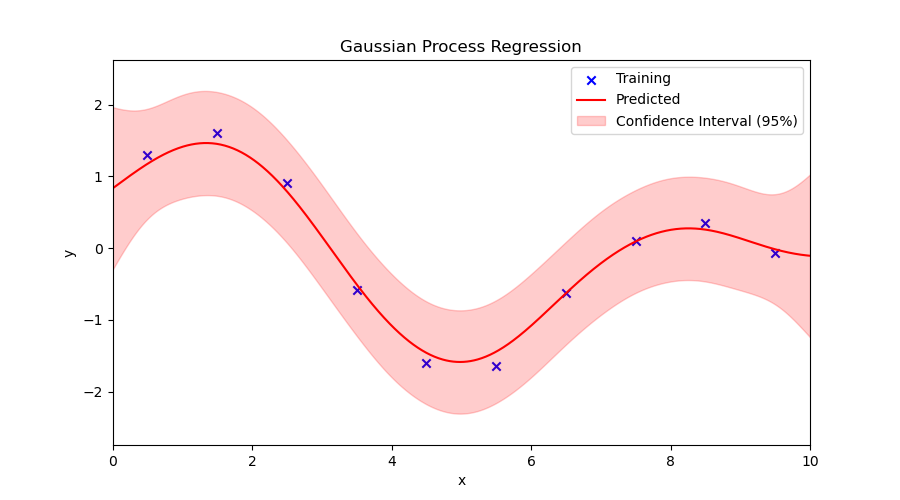

In [321]:
import numpy as np
import matplotlib.pyplot as plt
# Specify Hyperparameters and Sizes
n = 10
m = 1000
sigma2 = 0.1
tau = 1
l = 1
np.random.seed(116)

# Initialize Training set
X_train = np.linspace(0.5, 9.5,num = n)
Y_train = np.sin(X_train) +  np.cos(X_train/2) + 0.1* np.random.randn(n) # Training Label w/ noise

# Speficy Testing set
X_test = np.linspace(0, 10,num = m)

# Implement model
mu_star, cov_star = make_pred(X_train, Y_train, X_test, tau, l, sigma2)
std_star = np.sqrt(np.diag(cov_star)) # STD is the sqrt of the predictive covariance diagonal

# Plot posterior predictions
plt.figure(figsize=(9, 5),dpi=100)
plt.scatter(X_train, Y_train, color='blue', label='Training', marker='x')
plt.plot(X_test, mu_star, color = 'red', label = "Predicted")
plt.fill_between(
    X_test.ravel(),
    mu_star.ravel() - 1.96 * std_star,
    mu_star.ravel() + 1.96 * std_star,
    color='red',
    alpha=0.2,
    label='Confidence Interval (95%)'
)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim([0,10])
plt.ylim(
    mu_star.min() - 2 * std_star.max(),
    mu_star.max() + 2 * std_star.max()
)
#for i, sample in enumerate(samples):
#    plt.plot(X_test, sample, linestyle='--', label=f'Sample {i+1}')
plt.legend()
plt.title('Gaussian Process Regression')
plt.show()



#### GPR Interavtive Visualization
Here is an **Interactive Visualization** code example. By clicking, one could add an additional training data to the model, and observe the GPR model update.

In [322]:
%matplotlib widget
def on_click(event, X_train, Y_train, X_test, mu_line, fill, ax, count, tau, l, sigma2):
    
    if event.xdata is None or event.ydata is None:
        return  # Ignore clicks outside the plot area
    
    X_train.append([event.xdata])  # Append new x as a 2D row
    Y_train.append(event.ydata)   # Append new y as a scalar

    
    X_train_arr = np.array(X_train)  # Append new x as a 2D row
    Y_train_arr = np.array(Y_train)              # Append new y as a 1D value

    mu, cov = make_pred(X_train_arr, Y_train_arr, X_test, tau, l, sigma2)

    std = np.sqrt(np.diag(cov))

    mu_line.set_ydata(mu)
    
    if fill is not None:
        try:
            fill.remove()
        except ValueError:
            print("fill object is not valid for removal")
    fill = ax.fill_between(X_test.flatten(), mu - 2 * std, mu + 2 * std, color='red', alpha=0.2, label = "95% CI")
    ax.scatter(event.xdata, event.ydata, c = "blue", marker = 'x', label = "Training")  # Plot the new training point
    if(count[0] == 0): ax.legend()
    plt.draw()

    count[0] += 1
    ax.set_title(f"Interactive GP with {count[0]} Training Data")
    ax.set_ylim(
        mu.min() - 3 * std.max(),
        mu.max() + 3 * std.max()
    )
    
    return fill

def interactive_gp(X_test = np.linspace(0, 10, 200).reshape(-1, 1), tau = 1.0, l = 1.0, sigma2 = 0.1):
    # Initialize trianing data
    X_train = []
    Y_train = []
    Count = [0]
    # Initialize prediction
    mu_star, cov_star = make_pred(np.array([X_train]), np.array(Y_train), X_test, tau, l, sigma2)
    std = np.sqrt(np.diag(cov_star))

    # Plot the initial GP
    fig, ax = plt.subplots(figsize=(8,5),dpi=100)
    ax.set_xlim(X_test.min(), X_test.max())
    ax.set_ylim(-3, 3)
    ax.set_title(f"Interactive GP with {Count[0]} Training Data")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    mean_line, = ax.plot(X_test, mu_star, 'r-', lw=2, label = "Predicted")
    fill = ax.fill_between(X_test.flatten(), mu_star - 2 * std, mu_star + 2 * std, color='red', alpha=0.2 ,label = "95% CI")
    
    def handle_click(event):
        nonlocal fill  # Allow modification of the fill variable
        fill = on_click(event, X_train, Y_train, X_test, mean_line, fill, ax, Count, tau, l, sigma2)
    
    fig.canvas.mpl_connect('button_press_event', handle_click)
    plt.show()

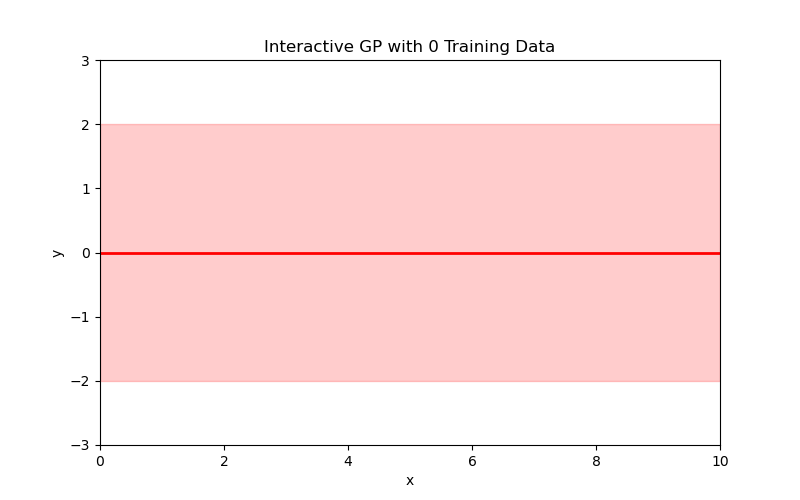

In [323]:
interactive_gp(tau=0.1)

#### 3.The role of hyperparameters
There are three hyperparameters in a GPR model **with the rbf kernel**: the kernel prefactor $\tau$, kernel lengthscale $l$, and the noise varianve $\sigma^2$. The following explanation and visualization examples facilitate understanding the roles of them in a GPR model with rbf kernel.

First, we wrap the plotting of a GPR model into a function to help our understanding:

In [324]:
import numpy as np
import matplotlib.pyplot as plt

def gpr_plot(X_train, Y_train, X_test, tau=1.0, l=1.0, sigma2=0.1, title = "Gaussian Process Regression", ax = None, Y_lim = None):
    """
    Plots Gaussian Process Regression (GPR) predictions with confidence intervals.

    This function takes training data, test inputs, and hyperparameters, performs Gaussian 
    Process regression, and returns a plot of the predicted mean with a 95% confidence interval.

    Parameters:
    -----------
    X_train : array-like, shape (d, n)
        The training input features.
    
    Y_train : array-like, shape (d, n)
        The training label values.
    
    X_test : array-like, shape (d, m)
        The test input features where predictions are made.

    tau : float, optional (default=1.0)
        The rbf prefactor.

    l : float, optional (default=1.0)
        The length scale parameter of the rbf kernel function.

    sigma2 : float, optional (default=0.1)
        The variance of the noise term in the observations.

    title : str, optional (default="Gaussian Process Regression")
        The title of the plot.
    
    ax : matplotlib.axes._subplots.AxesSubplot, optional
    If provided, the function will plot on this existing axis.
    Otherwise, it will create a new figure.

    Y_lim: list, optional (Default=None)
    If provided , the y-axes limit will be set to provided interval.
    Otherwise, the function will self-adapt.

    Returns:
    --------
    ax : matplotlib.axes._subplots.AxesSubplot
        The axis object containing the plot.
    """

    if ax is None:
        fig, ax = plt.subplots()

    # Implement model
    mu_star, cov_star = make_pred(X_train, Y_train, X_test, tau, l, sigma2)
    std_star = np.sqrt(np.diag(cov_star))

    # Plot posterior predictions
    ax.scatter(X_train, Y_train, color='blue', label='Training', marker='x')
    ax.plot(X_test, mu_star, color='red', label="Predicted")
    ax.fill_between(
        X_test.ravel(),
        mu_star.ravel() - 1.96 * std_star,
        mu_star.ravel() + 1.96 * std_star,
        color='red',
        alpha=0.2,
        label='Confidence Interval (95%)'
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    if Y_lim is None:
        Y_lim = [np.min([mu_star.min() - 2 * std_star.max(), np.min(Y_train) * 1.2]),
        np.max([mu_star.max() + 2 * std_star.max(), np.max(Y_train) * 1.2])]
    
    ax.set_xlim(
        X_test.min(),
        X_test.max())
    ax.set_ylim(Y_lim)
    ax.legend()
    ax.set_title(title)

    # Return the figure and axis
    return ax


##### Prefactor $\tau$
The prefactor $\tau$ is a scaling factor that directly affects the **variance** of the kernel function. It directly determines the **magnitude** of the covariance. 
- **Large $\tau$** leads to larger function values and larger confidence intervals.
- **Small $\tau$** leads to lower overall magnitude of prediction and smaller confidence intervals.

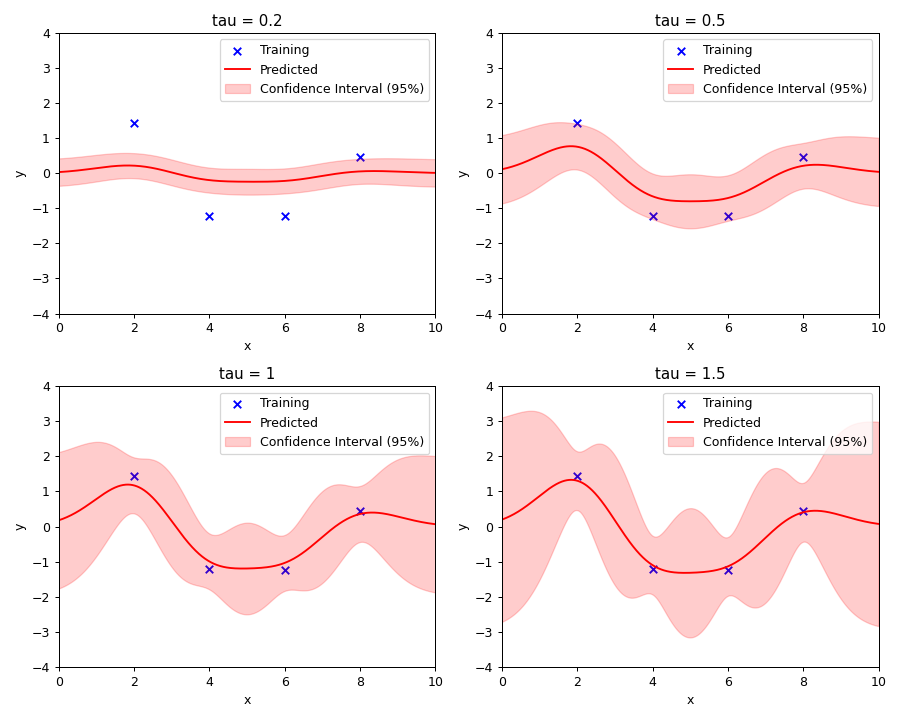

In [325]:
# Generate Sparse Training Data
n = 4
X_train = np.linspace(2,8,n)
Y_train = np.sin(X_train) +  np.cos(X_train/2) + 0.1* np.random.randn(n)

# Testing Data
m = 1000
X_test = np.linspace(0,10,m)

# Plot with different tau
tau = [0.2, 0.5, 1, 1.5]
fig, axes = plt.subplots(2, 2, figsize=(10, 8), dpi = 90)  # Creating a 2x2 subplot grid
for i, ax in enumerate(axes.flatten()):
    ax = gpr_plot(X_train, Y_train, X_test, tau = tau[i], title= f'tau = {tau[i]}', 
                  ax = ax, Y_lim= [-4,4])  # Call function
    
plt.tight_layout()
plt.show()


##### Lengthscale $l$
The lengthscale $l$ determines **How quickly** correlations between function values decay as inputs move apart. In another word, the lengthscale $l$ determines **how wide** a training datapoint can affect the predictied function.
- **Large $l$**: Rapid changes in function values (high flexibility, risk of overfitting)
- **Large $l$**: Very smooth function with long-range dependencies (underfitting)

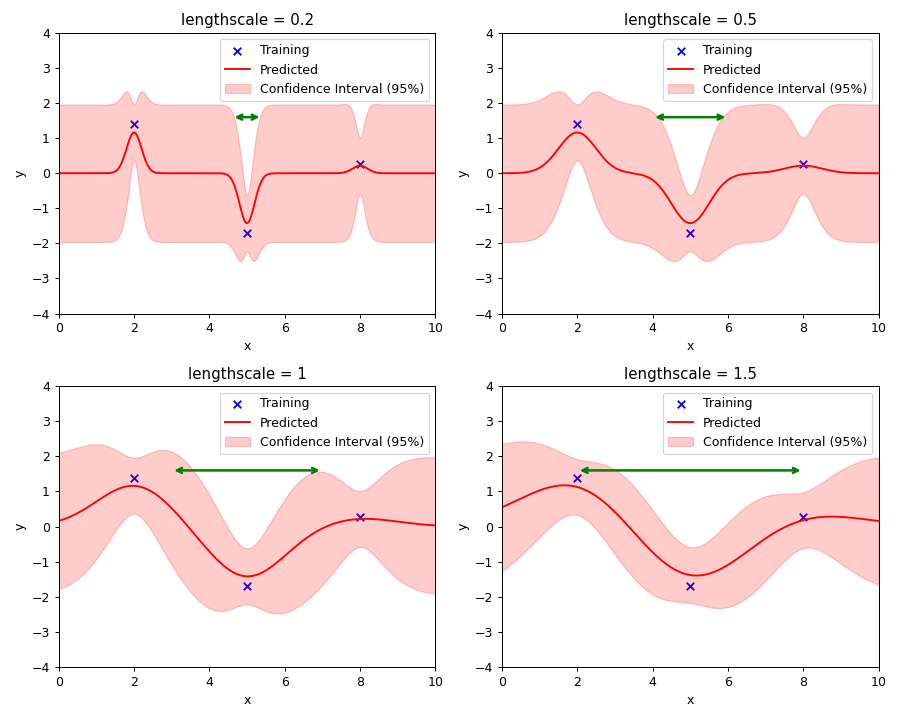

In [326]:
# Function to plot the influence range
def plot_influence_range(ax, X_train, l):
    influence_range = 2 * l  # Define influence range as 2*lengthscale
    mid_index = (X_train.shape[0] - 1) // 2
    ax.annotate("", xy=(X_train[mid_index] + influence_range, 1.6), xytext=(X_train[mid_index] - influence_range, 1.6),
                    arrowprops=dict(arrowstyle="<->", color="green", lw=2))

# Generate Sparse Training Data
n = 3
X_train = np.linspace(2,8,n)
Y_train = np.sin(X_train) +  np.cos(X_train/2) + 0.1* np.random.randn(n)

# Testing Data
m = 1000
X_test = np.linspace(0,10,m)

# Plot with different tau
l = [0.2, 0.5, 1, 1.5]
fig, axes = plt.subplots(2, 2, figsize=(10, 8), dpi = 90)  # Creating a 2x2 subplot grid
for i, ax in enumerate(axes.flatten()):
    ax = gpr_plot(X_train, Y_train, X_test, l = l[i], title= f'lengthscale = {l[i]}', 
                  ax = ax, Y_lim= [-4,4])  # Call function
    plot_influence_range(ax, X_train, l[i])

plt.tight_layout()
plt.show()


<div style="text-align: center"> <b>The above plots show the role of lengthscale on a GPR model. The green double arrow represents the width of impact on the predicted function from one single training data point. </div>

##### Noise Variance $\sigma^2$
The noise variance $\sigma^2$ is the only hyperparameter that does not appear in the rbf kernel. The role of noise variance is to control the **Assumed amount of noise** in the observations (training data).
- **Small $\sigma^2$: Assumes data is almost noise-free, leading to overfitting. The confidence interval near a training point will be small.**
- **Small $\sigma^2$: Assumes data is very noisy, leading to underfitting (overly smooth). The confidence interval near a training point will be big.**

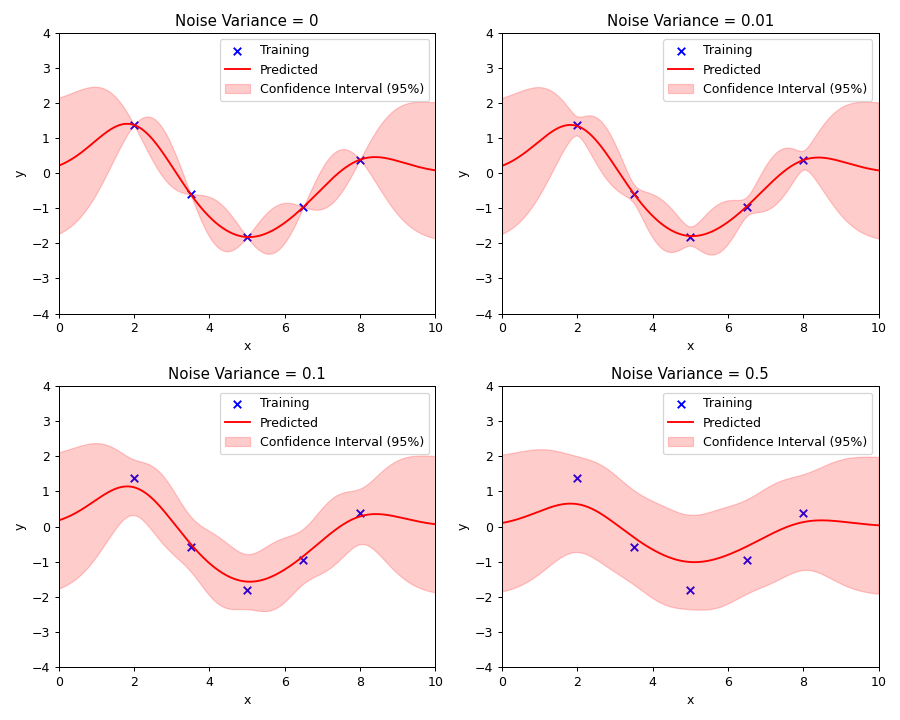

In [327]:
# Generate Sparse Training Data
n = 5
X_train = np.linspace(2,8,n)
Y_train = np.sin(X_train) +  np.cos(X_train/2) + 0.1* np.random.randn(n)

# Testing Data
m = 1000
X_test = np.linspace(0,10,m)

# Plot with different tau
sigma2 = [0, 0.01, 0.1, 0.5]
fig, axes = plt.subplots(2, 2, figsize=(10, 8), dpi = 90)  # Creating a 2x2 subplot grid
for i, ax in enumerate(axes.flatten()):
    ax = gpr_plot(X_train, Y_train, X_test, sigma2 = sigma2[i], title= f'Noise Variance = {sigma2[i]}', 
                  ax = ax, Y_lim= [-4,4])  # Call function
plt.tight_layout()
plt.show()


#### 5.GPR Using Libraries
Eventhough constructing a GPR model from scratch is beneficial when studying, using a sophisticated package to perform actual modeling and prediction is more stable and efficient. **GPytorch** is a well-developed package based on pytorch, and it will be explained below.

GPyTorch is built on PyTorch, which uses **object-oriented programming (OOP)**principles. In GPyTorch, we define a Gaussian Process model by creating a child class that inherits from `gpytorch.models.ExactGP`.

##### Torch Tensors
While using GPytorch to perform gaussian process regression, it is important to use **torch tensors** instead of numpy arrays. This is because GPytorch is built on Pytorch, whose tensor operations enable **GPU acceleration, automatic differentiation, efficient memory management, etc**. 
- To convert numpy array to torch tensor: `torch.from_numpy(np.array)`
- To convert a tensor `x` back to an numpy array:`x.numpy()`. This is useful when we try to **plot**, because libraries like matplotlib does not support torch tensor as input.

##### Required Objects
To fully construct a gpr model child class from gpytorch, we need to define 4 essential objects, in addition to the model itself.
- A **Likelihood**. The most common likelihood used is `gpytorch.likelihoods.GaussianLikelihood`, which is also the one explained earlier in this notebook.
- A **Mean**, which defines the GP prior mean. Usually we use `gpytorch.means.ConstantMean()`
- A **Kernel Function**. We can continue to use the rbf kernel explained earlier with `gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())` or other kernels.
- A **MultivariateNormal** distribution, using `gpytorch.distributions.MultivariateNormal`.

##### Define a Model
If we are sticking with rbf kernel, we can define a model object without allowing passing a parameter to specify the kernel function used. In order to construct a fully functioning model, we need to construct:
1. The **Constructor**: which helps construct a model object. We can use the parent `ExactGP` class constructor. We need to pass three parameters in the constructor: **training features, training labels, and likelihood**.
2. A **forward** function that allows us to train the model.

In [328]:
import torch
import gpytorch
import matplotlib.pyplot as plt

# Define the GP Model as a class
class GPRmodel(gpytorch.models.ExactGP):
    
    # 1. Constructor
    def __init__(self, train_x, train_y, likelihood):
        # Call the parent class (ExactGP) constructor
        super().__init__(train_x, train_y, likelihood)
        
        # Define the mean function (ZeroMean in GP Prior)
        self.mean_module = gpytorch.means.ConstantMean()

        # Define the covariance function (RBF Kernel)
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    # 2. Forward function
    def forward(self, x):
        mean_x = self.mean_module(x)  # Compute mean
        covar_x = self.covar_module(x)  # Compute covariance
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

An important note is that in the GPytorch framework, calling the instance means **redirect to the forward function**. This means that in practice, for a model `model = GPRmodel(train_x,train_y,likelihood)`, calling `model(x)` **is equivalent to** `model.forward(x)`.

##### Modes of model and likelihood
In Gpytorch (actually inherited from Pytorch), each model (and likelihood) has **two modes**:
1. `model.train()` and `likelihood.train()`. This is the default mode, which allows hyperparameter changing. This mode is used during the training phase (Note that because in GPR the predictive mean and covariance have **closed form**, there is no training step for these two outputs. The training in Gpytorch is referring to **hyperparameter tuning**, which will be explained in the next chapter.)
2. `model.eval()` and `likelihood.eval()`This mode **freezes** the model, forbidding any form of hyperparameter changing. It is used during prediction phase.

##### Constructing a Model (without hyperparameter tuning)
After defining a GPRmodel class, we can move forward to construct a model and train it. Note that here we **assume** we know the optimized hyperparameters ($\tau,\,l,\,\sigma^2$). We are still telling the model to predict the same function we used before:
$$Y=\sin(x)+\cos(\frac{x}{2})+\epsilon$$

In [329]:
import torch
import gpytorch
# Generate training data
train_x = torch.linspace(0,10,10)
train_y = torch.sin(train_x) + torch.cos(train_x/2) + 0.1 * torch.randn(train_x.size())

# Define Gaussian Likelihood
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# Create a GPR model
model = GPRmodel(train_x, train_y, likelihood)

# Define Hyperparameters
model.covar_module.outputscale = 1.0 # prefactor tau
model.covar_module.base_kernel.lengthscale = 1.0 # lengthscale l
likelihood.noise = 0.1 # noise variance

##### Making predictions
Now we have a working model, we use the model to make predictions and visualize it.

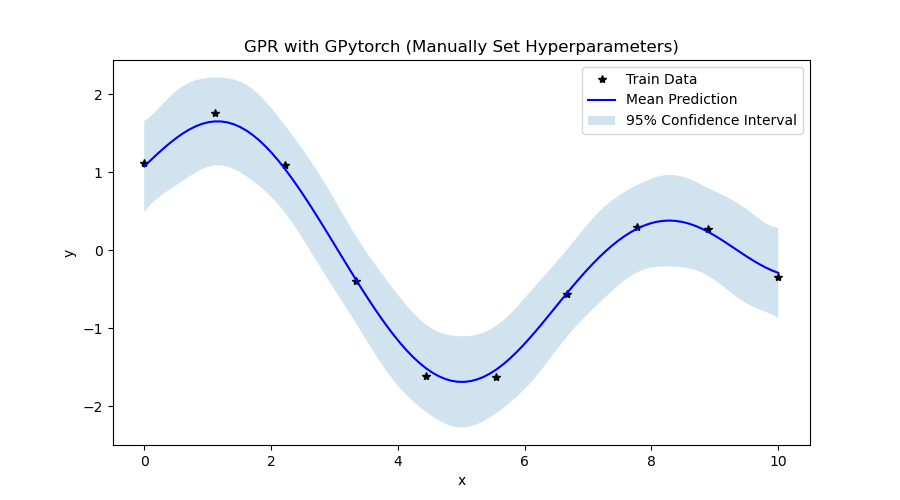

In [330]:
# Generate testing data
test_x = torch.linspace(0,10,100)

# Make sure model and likelihood is in evaluation mode
model.eval()
likelihood.eval()

# Make predictions
with torch.no_grad(): # Skip gradient tracking to save time & memory space
    pred_dis = model(test_x) # Obtain predictive distribution
    mu_star = pred_dis.mean # Predictive mean
    cov_star = pred_dis.covariance_matrix # Predictive covariance matrix; optional because we don't need it to plot
    std_star = pred_dis.variance.sqrt() # Predictive standard deviation

# Plot results
plt.figure(figsize=(9, 5),dpi=100)
plt.plot(train_x.numpy(), train_y.numpy(), 'k*', label='Train Data')
plt.plot(test_x.numpy(), mu_star.numpy(), 'b', label='Mean Prediction')
plt.fill_between(test_x.numpy(),
                 (mu_star - 1.96 * std_star).numpy(),
                 (mu_star + 1.96 * std_star).numpy(),
                 alpha=0.2, label='95% Confidence Interval')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title("GPR with GPytorch (Manually Set Hyperparameters)")
plt.show()

### **Gaussian Process Hyperparameter Tuning (rbf kernel)**
The three hyperparameters in GPR (with rbf kernel) mentioned above cannot be learned from training data; instead, it need to be trained.
#### 1.Mathematic Foundation
The most popular method of training hypermarameters is **Maximum Likelihood Estimation(MLE)**, which was introduced in the *fundamental* notebook.

Here, we treat the three hyperparameters $\tau,\,l,\,\sigma^2$ as one parameter vector $\Theta=[\tau,l,\sigma^2]$. As MLE states, we define a **likelihood function** of $\Theta$ given observation $X$ and $Y$:
$$P(Y|X,\Theta)=[(2\pi)^{n/2}\cdot |K+\sigma^2I|^{1/2}]^{-1}\exp(-\frac{1}{2}Y(K+\sigma^2I)^{-1}Y^T) \\ K=k(X,X)$$
Then, we derive the **log likelihood function** (also called the log marginal likelihood **LML**):
$$\log{P(Y|X,\Theta)}=-\frac{1}{2}Y(K+\sigma^2I)^{-1}Y^T-\frac{1}{2}\log{|K+\sigma^2I|}-\frac{n}{2}\log(2\pi)$$
With the expression, we can therefore find the optimized parameter vector $\Theta^*$:
$$\Theta^* = \arg\max_{\Theta} \log P(Y | X, \Theta)$$

#### 2.Gradient Based Methods
To perform optimization on the log marginal likelihood LML, we can utilize gradient based methods, because an LML is **Differentiable**.

**Gradient-based methods** optimize a function **iteratively** by computing its gradient and updating parameters multiple times in the direction that minimizes (or maximizes) the function. 

##### Key parameters for Optimization with Gradient Based Methods
1. Number of Epochs: Defines how many **times** the optimizer update the parameters. Typical `50-500`
2. Loss Function
3. Stepsize/Learning Rate: Controls how much hyperparameters change at each step (each epoch). Typical `0.01-0.1`
    - Too **Small**: may get stuck in local minima/maxima
    - Too **big**: may diverge
4. Stoping Criteria: instruct the method to stop by placing a limit, regardless of epochs. Could be:
    - The loss function change is **below a certain threshold** (for example `1e-6`)
    - The improvement in LML is negligible.
5. Optimizer: the choise of optimizer. Explained below

##### Optimizers
There are plenty availeble gradient based methods for use. The most popular ones in GPytorch are:
1. Adam(adaptive moment estimation)`torch.optim.Adam`: a modified method based on stochastic gradient descent (SGD). It adds **adaptive learning rates** (incorporating momentum) to accelerate convergence.
2. L-BFGS (Limited-memory Broyden-Fletcher-Goldfarb-Shanno)`torch.optim.LBFGS`: It approximates **second-order derivatives** (Hessian matrix) efficiently to accelerate convergence. It also uses adaptive learning rate. However, because of its **batch optimizer nature**, each step peforms **multiple iterations** before returning. This means an L-BFGS model requires another parameter `max_iter` to specify the number of iterations run in each epoch. As a result, L-BFGS requires **lower number of epoches** compare to other methods like Adam.

| **Factor**               | **lbfgs** | **L-BFGS** |
|--------------------------|---------|---------|
| **1. Problem Size**      | ✅ Best for large datasets (≥ 1M points) | ✅ Best for small-to-medium datasets (≤ 10,000 points) |
| **2. Convexity**         | ✅ Works well for non-convex problems | ❌ May get stuck in local minima; best for convex functions |
| **3. Memory Usage**      | ✅ Low (stores only first & second moments) | ❌ High (stores past gradients & Hessian approximation) |
| **4. Computational Efficiency** | ❌ More iterations needed (but cheaper per iteration) | ✅ Fewer iterations needed (but each is more expensive) |
| **5. Learning Rate Tuning** | ⚠️ Needs tuning (default `lr=0.001` usually works) | ✅ Adaptive step size (no tuning required) |
| **6. Stopping Criteria & Stability** | ❌ May oscillate, needs early stopping | ✅ Automatically stops when converged, more stable |

#### 3.Implementation in GPytorch

##### Key Parameters Initialization
The **5 key parameters** in optimization mentioned above can be specified in Gpytorch as follows:
1. Number of Epoches: 
    - for Adam:`num_epoch = 50`
    - for L-BFGS: `num_epoch = 10`
2. Loss function: By default we use the **Exact Marginal Log Likelihood (MLL)** in Gpytorch as our loss function:`mll=gpytorch.mlls.ExactMarginalLogLikelihood(likelihood,model)`
3. Stepsize: this parameter will be defined within **Optimizer** with `lr`.
4. Stopping Criteria: since we are using a relatively small number of epoch, we can skip defining the stopping criteria and let the model finish 50/5 epoches.
5. Optimizer: we need to pass the parameters in our model (the hyperparameters, represented by`model.parameters()`in GPytorch). Note that **L-BFGS method** requires another parameter `max_iter`.
    - Adam: `torch.optim.Adam(model.parameters(), lr = 0.1)`
    - L-BFGS: `torch.optim.LBFGS(model.parameters(), lr = 0.1, max_iter=20)`

##### Optimization - Adam
For each epoch, we need the adam optimizer to peform these tasks:
1. Clear all old gradients to make sure we have a fresh start: `adam_optimizer.zero_grad()`
2. Passes `train_x` through the model and acquire posterior distribution for loss function computation
3. Compute negative LML. We **negate** the LML because Pytorch optimizers **minimize** the loss function.
4. Compute gradient: `loss.backward()`. The function used is the audomatic differentiation in Pytorch via backpropagation.
5. Update model parameters with `adam_optimizer.step()`.

In [331]:
# Initialize model
adam_model = GPRmodel(train_x, train_y, likelihood)
adam_model.train()
likelihood.train()

adam_optimizer = torch.optim.Adam(adam_model.parameters(), lr = 0.1)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, adam_model)

# Training
adam_epoch = 50
for i in range(adam_epoch):
    adam_optimizer.zero_grad() # Clear old gradients
    output = adam_model(train_x) # Obtain posterior distribution 
    loss = -mll(output, train_y) # Compute negative loss function
    loss.backward() # Calculate loss function gradient
    adam_optimizer.step() # Step forward
    print(f'Epoch{i} - loss:{loss.item():.3f}')

Epoch0 - loss:1.333
Epoch1 - loss:1.295
Epoch2 - loss:1.254
Epoch3 - loss:1.215
Epoch4 - loss:1.175
Epoch5 - loss:1.132
Epoch6 - loss:1.086
Epoch7 - loss:1.039
Epoch8 - loss:0.994
Epoch9 - loss:0.951
Epoch10 - loss:0.911
Epoch11 - loss:0.874
Epoch12 - loss:0.840
Epoch13 - loss:0.808
Epoch14 - loss:0.779
Epoch15 - loss:0.753
Epoch16 - loss:0.729
Epoch17 - loss:0.708
Epoch18 - loss:0.688
Epoch19 - loss:0.669
Epoch20 - loss:0.652
Epoch21 - loss:0.634
Epoch22 - loss:0.617
Epoch23 - loss:0.600
Epoch24 - loss:0.583
Epoch25 - loss:0.567
Epoch26 - loss:0.552
Epoch27 - loss:0.538
Epoch28 - loss:0.525
Epoch29 - loss:0.512
Epoch30 - loss:0.501
Epoch31 - loss:0.490
Epoch32 - loss:0.480
Epoch33 - loss:0.471
Epoch34 - loss:0.462
Epoch35 - loss:0.453
Epoch36 - loss:0.444
Epoch37 - loss:0.436
Epoch38 - loss:0.428
Epoch39 - loss:0.421
Epoch40 - loss:0.415
Epoch41 - loss:0.409
Epoch42 - loss:0.404
Epoch43 - loss:0.399
Epoch44 - loss:0.394
Epoch45 - loss:0.390
Epoch46 - loss:0.386
Epoch47 - loss:0.382
Ep

##### L-BFGS Optimization
In L-BFGS optimization, we need to make some changes on the codes we had for Adam:
1. We need a `closure` function to peform step 1-4 in adam. because L-BFGS is a **second order, batch optimizer**, and it peforms multiple internal updates per step before returning (here `max_iter=20`)
2. The `step()` need to be peformed outside the `closure` function, in each epoch.
3. Is important to **Initialize** the parameters and place a **cholesky jitter** on the model to increase stability.

In [332]:
# Initialize model
import torch.optim.lbfgs

lbfgs_model = GPRmodel(train_x, train_y, likelihood)
lbfgs_model.train()
likelihood.train()

lbfgs_optimizer = torch.optim.LBFGS(lbfgs_model.parameters(), lr = 0.1, max_iter = 5)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, lbfgs_model)

# Initialize parameters
lbfgs_model.covar_module.base_kernel.initialize(lengthscale=1.0)  # Ensure reasonable lengthscale
lbfgs_model.covar_module.initialize(outputscale=1.0)  # Ensure reasonable prefactor
likelihood.noise = 0.1  # Ensure noise variance is not too small

# Add jitter to the kernel matrix
gpytorch.settings.cholesky_jitter(1e-4)

# Closure Function
def closure():
    lbfgs_optimizer.zero_grad() # Clear old gradients
    output = lbfgs_model(train_x) # Obtain posterior distribution 
    loss = -mll(output, train_y) # Compute negative loss function
    loss.backward() # Calculate loss function gradient
    return loss

# Training
lbfgs_epoch = 10 # For L-BFGS, smaller num of epoch is ok
for i in range(lbfgs_epoch):
    loss = lbfgs_optimizer.step(closure) #Step forward
    print(f'Epoch{i} - loss:{loss.item():.3f}')

Epoch0 - loss:1.155
Epoch1 - loss:0.806
Epoch2 - loss:0.494
Epoch3 - loss:0.394
Epoch4 - loss:0.365
Epoch5 - loss:0.353
Epoch6 - loss:0.346
Epoch7 - loss:0.343
Epoch8 - loss:0.341
Epoch9 - loss:0.340


##### Visual Comparison between Adam and L-GFBS
With this dataset, the peformance between adam and l-bfgs is **negligible**.

Text(0.5, 1.0, 'L-BFGS Optimizer')

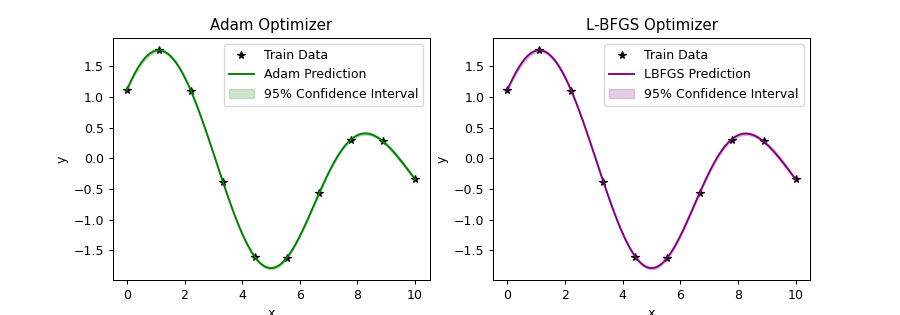

In [333]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3.5), dpi = 90)


# Obtain predictions
adam_model.eval()
lbfgs_model.eval()
likelihood.eval()

with torch.no_grad(): # Skip gradient tracking to save time & memory space
    adam_pred = adam_model(test_x) # Obtain predictive distribution
    adam_mu = adam_pred.mean # Predictive mean
    adam_std = adam_pred.variance.sqrt() # Predictive standard deviation

with torch.no_grad():
    lbfgs_pred = lbfgs_model(test_x)
    lbfgs_mu = lbfgs_pred.mean
    lbfgs_std = lbfgs_pred.variance.sqrt()

# Plot training data
ax[0].plot(train_x.numpy(), train_y.numpy(), 'k*', label='Train Data')
ax[1].plot(train_x.numpy(), train_y.numpy(), 'k*', label='Train Data')

# Plot prediction
ax[0].plot(test_x.numpy(), adam_mu.numpy(), 'g', label='Adam Prediction')
ax[1].plot(test_x.numpy(), lbfgs_mu.numpy(), 'purple', label='LBFGS Prediction')

ax[0].fill_between(test_x.numpy(),
                 (adam_mu - 1.96 * adam_std).numpy(),
                 (adam_mu + 1.96 * adam_std).numpy(), color = 'green',
                 alpha=0.2, label='95% Confidence Interval')
ax[1].fill_between(test_x.numpy(),
                 (lbfgs_mu - 1.96 * lbfgs_std).numpy(),
                 (lbfgs_mu + 1.96 * lbfgs_std).numpy(), color = 'purple',
                 alpha=0.2, label='95% Confidence Interval')

ax[0].legend()
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title("Adam Optimizer")

ax[1].legend()
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_title("L-BFGS Optimizer")

#### 4.Rationale behind tuning hyper parameters
Is hyperparameter tuning necessary in modeling? In other words, if we choose a set of hyperparameter at first without tuning, will the GPR model find the underlying function given an infinitely large number of datapoint, regarless of its value?

Here, we set the model to be a **simple sine wave** $y=\sin(x)+\epsilon$ with gaussian noise variance of 0.1. Our strategy would be:
1. Before we impose any values on hyperparameters, we initialize the values to be 
    -$l$=1.5
    -$\tau$=1.0
    -$\sigma^2$=0.1
2. For each hyperparameter, we both **overestimate** and **underestimate**, constituting 6 overall experiment sections.
3. For each section, we both try
    - adding repeated datapoint on fixed $x$ values.
    - adding datapoint with various values, within a fixed range

For simplicity, we define two functions to generate training data, and a function to plot.

In [334]:
import torch
import gpytorch

import torch

def gen_repeat_data(loc=torch.linspace(0, 10, 10), num_repeat=100):
    """
    Generates repeated x-values and corresponding noisy sine values on chosen location

    Parameters:
        loc (torch.Tensor, optional): A tensor of x-values to be repeated. Defaults to 10 evenly spaced points between 0 and 10.
        num_repeat (int, optional): The number of times each x-value should be repeated. Defaults to 100.

    Returns:
        tuple: A tuple (x, y) where:
            - x (torch.Tensor): A 1D tensor containing repeated x-values.
            - y (torch.Tensor): A 1D tensor containing sine values of x with added Gaussian noise.
    """
    torch.manual_seed(116)
    x = torch.repeat_interleave(loc, num_repeat)
    y = torch.sin(x) + 0.1 * torch.randn(x.size())
    return x, y

def gen_data(num=1000):
    """
    Generates evenly spaced x-values and corresponding noisy sine values between 0 and 10.

    Parameters:
        num (int, optional): The number of evenly spaced points to generate. Defaults to 1000.

    Returns:
        tuple: A tuple (x, y) where:
            - x (torch.Tensor): A 1D tensor of `num` evenly spaced values between 0 and 10.
            - y (torch.Tensor): A 1D tensor containing sine values of x with added Gaussian noise.
    """
    torch.manual_seed(116)
    x = torch.linspace(0, 10, num)
    y = torch.sin(x) + 0.1 * torch.randn(x.size())
    return x, y

def plot_model(likelihood, train_x, train_y, test_x, ax, tau = 1.0, l = 1.5, sigma2 = 0.1, title = "Gaussian Process Regression"):
    """
    Plots the results of a Gaussian Process Regression model.

    Parameters:
        likelihood (gpytorch.likelihoods.Likelihood): Likelihood function associated with the model.
        train_x (torch.Tensor): Training input data (features).
        train_y (torch.Tensor): Training target data (labels).
        test_x (torch.Tensor): Test input data where predictions will be made.
        ax (matplotlib.axes.Axes): Matplotlib axis object to plot on.
        tau (torch.Tensor): rbf prefactor tau
        l (torch.Tensor): rbf lengthscale l
        sigma2 (torch.Tensor): noise variance sigma^2
        title (str, optional): Title of the plot. Defaults to "Gaussian Process Regression".

    Returns:
        matplotlib.axes.Axes: The axis object with the plotted results.
    """
    # Train model
    model = GPRmodel(train_x, train_y, likelihood)
    model.covar_module.outputscale = tau
    model.covar_module.base_kernel.lengthscale = l
    likelihood.noise = sigma2
    
    # Obtain Prediction
    model.eval()
    likelihood.eval()
    with torch.no_grad(): # Skip gradient tracking to save time & memory space
        pred = model(test_x) # Obtain predictive distribution
        mu = pred.mean # Predictive mean
        std = pred.variance.sqrt() # Predictive standard deviation

    # Plot
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*', alpha = 0.3, label='Train Data')
    ax.plot(test_x.numpy(), mu.numpy(), 'b', label='Prediction')

    ax.fill_between(test_x.numpy(),
                    (mu - 1.96 * std).numpy(),
                    (mu + 1.96 * std).numpy(), color = 'b',
                    alpha=0.2, label='95% Confidence Interval')
    
    ax.legend(loc = "upper center", fontsize = 7)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(title)
    return ax

In [335]:
test_x = torch.linspace(0,10,100)

# generate Bulk data
train_data = [gen_data(n) for n in [10, 100, 1000, 5000]]
train_x_bulk, train_y_bulk = zip(*train_data)

# generate repeat data
train_data = [gen_repeat_data(num_repeat=n) for n in [1, 10,100,500]]
train_x_repeat, train_y_repeat = zip(*train_data)

##### Prefactor $\tau$
Here we will try to both **underestimate** and **overestimate** $\tau$, and see if the model can still figure out the underlying function with increasing number of training points wihtin a fixed range. 

**Overestimation**: We set the prefactor to be $10$, which is much larger than the amplitude of the sine wave.

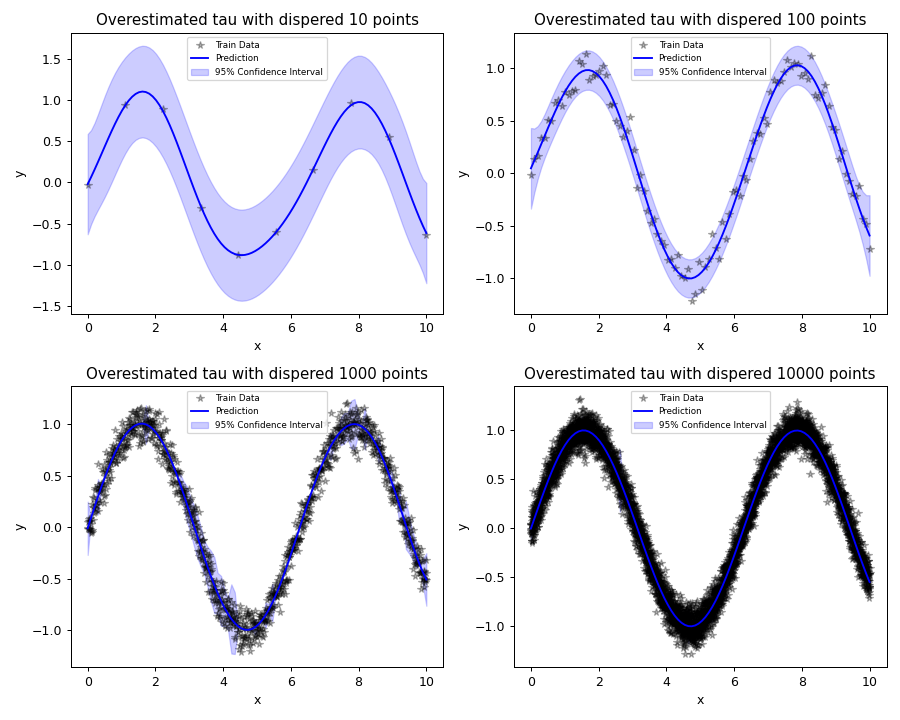

In [336]:
# Titles in subplot
titles = [f"Overestimated tau with dispered {n} points" for n in [10,100,1000,10000]]

# Plot with bulk data
fig, axes = plt.subplots(2,2, figsize=(10,8),dpi=90)
for x, y, ax, title in zip(train_x_bulk, train_y_bulk, axes.flatten(), titles):
    plot_model(likelihood = likelihood, train_x = x, train_y = y, 
           test_x = test_x, ax = ax, tau = 10, title = title)
    
plt.tight_layout()


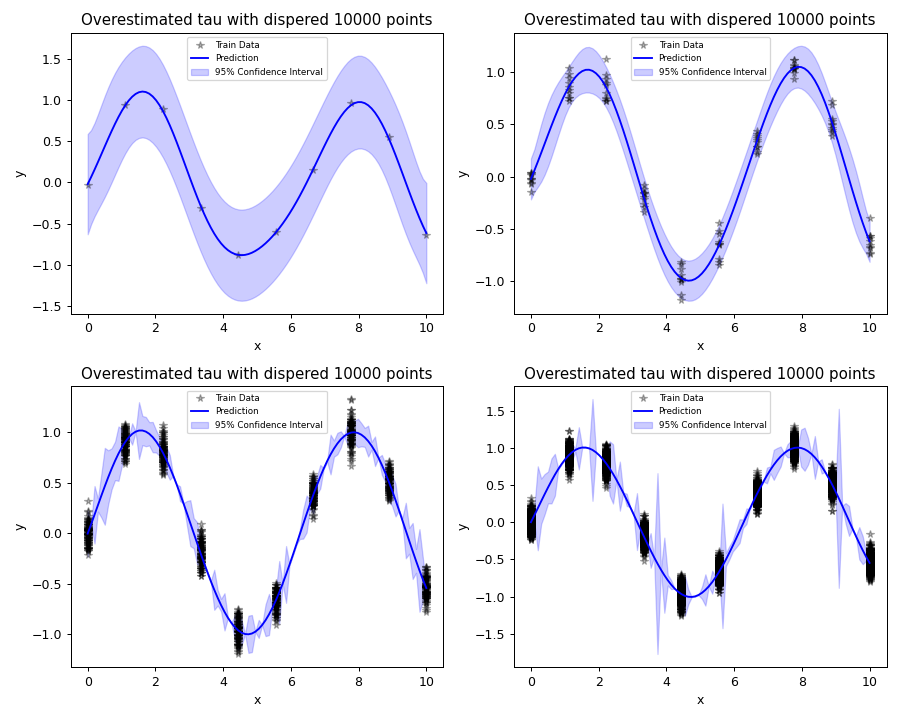

In [337]:
# Titles in subplot
titles = [f"Overestimated tau with repeated {n} points" for n in [10,100,1000,10000]]

# Plot with repeated data
fig, axes = plt.subplots(2,2, figsize=(10,8),dpi=90)

for x, y, ax in zip(train_x_repeat, train_y_repeat, axes.flatten()):
    plot_model(likelihood=likelihood, train_x=x, train_y=y, 
           test_x=test_x, ax = ax, tau = 10, title = title)
    
plt.tight_layout()